In [1]:
import requests
import pandas as pd


In [2]:
import os
os.environ["SSL_CERT_FILE"] = "Fortinet_CA_SSL(15).cer"


# Load documents with IDs and ground truth

In [3]:
url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [4]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [5]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [6]:
doc_idx={d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

# Index data

In [7]:
pip install sentence_transformers --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [8]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

In [9]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [10]:
from elasticsearch import Elasticsearch

In [11]:
es_client = Elasticsearch("http://localhost:9200")

In [14]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector":{
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity":"cosine"
            }
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [15]:
import numpy as np
np.float_ = np.float64

In [16]:
from tqdm import tqdm 

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [03:34<00:00,  4.42it/s]


# Retrieval

In [17]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter":{
            "term":{
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )

    result_docs = []

    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [18]:
def question_text_vector_knn(q):
    question = q ['question']
    course = q['course']

    v_q = model.encode(question)
    return elastic_search_knn ('question_text_vector', v_q, course)

In [19]:
question_text_vector_knn(dict(
    question= 'Are sessions recorded if I miss one?',
    course = 'machine-learning-zoomcamp',
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

In [20]:
from mistralai import Mistral
from mistralai.models import UserMessage
import os
from dotenv import load_dotenv

In [21]:
# loads variables from .env
load_dotenv()  

True

In [22]:
api_key = os.getenv("API_KEY")

In [23]:
client = Mistral(api_key = api_key)

In [24]:
def llm(prompt):
    response = client.chat.complete(
        model= "open-mistral-7b",
        messages=[UserMessage(content=prompt)],
    )


    return response.choices[0].message.content

In [25]:
def build_prompt(query, search_results):

    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

    context = ""

    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"

    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt


In [26]:
def rag(query:dict) ->str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt)
    return answer

In [27]:
rag(ground_truth[10])

"Based on the provided context, if you miss a session, the recorded sessions will be available for you to watch at your convenience. However, since the course videos are pre-recorded, the live sessions that might include office hours are also recorded. You can find these recordings in the course playlist on YouTube. If you have specific questions, you can ask them in advance or use the Slack channel for communication. It's important to note that certificates are usually awarded based on course completion, so missing the midterm project might affect your eligibility for a certificate, but it's best to refer to the specific course policies for more details."

In [28]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

# Cosine similarity metric

In [29]:
answer_org = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'
answer_llm = "Based on the provided context, sessions are recorded if you miss one. You can watch the recorded sessions at your convenience. However, it's not specified if the recorded sessions include the specific content that was presented during the missed session. office hours are also recorded, and you can ask your questions in advance for these sessions."

v_llm = model.encode(answer_llm)
v_org = model.encode(answer_org)

v_llm.dot(v_org)


np.float32(0.5774827)

In [30]:
ground_truth[4]

{'question': 'How can I structure my questions and answers for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [31]:
answers = {}

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
        
    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_org = original_doc['text']
    question = original_doc['question']

    answers[i] = {
        'question': question,
        'answer_llm': answer_llm,
        'answer_org': answer_org, 
        'course': rec['course'],
        'document': doc_id
    }



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [45:05<00:00,  1.48s/it]


In [34]:
results_llm = [None] * len(ground_truth)

for i, val in answers.items():
    results_llm[i] = val.copy()
    results_llm[i].update(ground_truth[i])

In [36]:
import pandas as pd

In [37]:
df_llm = pd.DataFrame(results_llm)

In [38]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
df_llm.to_csv('data/results-llm.csv', index=False)

In [40]:
df_llm

,question,answer_llm,answer_org,course,document
0,Where can I sign up for the course?,"To sign up for the course, you can access the ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872
1,Can you provide a link to sign up?,"To sign up for the Machine Learning Zoomcamp, ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872
2,Is there an FAQ for this Machine Learning course?,"Based on the provided context, there does not ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872
3,Does this course have a GitHub repository for ...,"Based on the provided context, this course doe...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872
4,How can I structure my questions and answers f...,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872
...,...,...,...,...,...
1825,What are some suggested titles for listing the...,"Based on the context provided, some suggested ...",I’ve seen LinkedIn users list DataTalksClub as...,machine-learning-zoomcamp,c6a22665
1826,Should I list the Machine Learning Zoomcamp ex...,"Based on the provided context, it is best advi...",I’ve seen LinkedIn users list DataTalksClub as...,machine-learning-zoomcamp,c6a22665
1827,In which LinkedIn sections can I incorporate m...,"Based on the context provided, you can incorpo...",I’ve seen LinkedIn users list DataTalksClub as...,machine-learning-zoomcamp,c6a22665
1828,Who gave advice on including a project link in...,Annaliese Bronz gave advice on including a pro...,I’ve seen LinkedIn users list DataTalksClub as...,machine-learning-zoomcamp,c6a22665


## Cosine similarity

In [43]:
result_llm = df_llm.to_dict(orient='records')

In [45]:
record = result_llm[0]

In [46]:
record

{'question': 'Where can I sign up for the course?',
 'answer_llm': "To sign up for the course, you can access the course page at http://mlzoomcamp.com/. If you've already joined, you can start going through the course materials by clicking on the links and starting to watch the videos. You can also find the course playlist on YouTube. Since the course videos are pre-recorded, you can start watching the course right now. To receive a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ projects by the deadline. You will need to provide the URL to your GitHub repo to receive a grade for your homework questions.",
 'answer_org': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s 

In [51]:
def compute_similarity(record):

    answer_org = record['answer_org']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_org = model.encode(answer_org)
    
    return v_llm.dot(v_org)


In [52]:
similarity = []

for record in tqdm(result_llm):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [01:38<00:00, 18.60it/s]


In [53]:
df_llm['cosine'] = similarity

In [54]:
df_llm

,question,answer_llm,answer_org,course,document,cosine
0,Where can I sign up for the course?,"To sign up for the course, you can access the ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872,0.377051
1,Can you provide a link to sign up?,"To sign up for the Machine Learning Zoomcamp, ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872,0.701019
2,Is there an FAQ for this Machine Learning course?,"Based on the provided context, there does not ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872,0.645183
3,Does this course have a GitHub repository for ...,"Based on the provided context, this course doe...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872,-0.031052
4,How can I structure my questions and answers f...,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,machine-learning-zoomcamp,0227b872,0.364987
...,...,...,...,...,...,...
1825,What are some suggested titles for listing the...,"Based on the context provided, some suggested ...",I’ve seen LinkedIn users list DataTalksClub as...,machine-learning-zoomcamp,c6a22665,0.819249
1826,Should I list the Machine Learning Zoomcamp ex...,"Based on the provided context, it is best advi...",I’ve seen LinkedIn users list DataTalksClub as...,machine-learning-zoomcamp,c6a22665,0.771161
1827,In which LinkedIn sections can I incorporate m...,"Based on the context provided, you can incorpo...",I’ve seen LinkedIn users list DataTalksClub as...,machine-learning-zoomcamp,c6a22665,0.622954
1828,Who gave advice on including a project link in...,Annaliese Bronz gave advice on including a pro...,I’ve seen LinkedIn users list DataTalksClub as...,machine-learning-zoomcamp,c6a22665,0.387650


In [59]:
# Explore the onw with (-) cosine
df_llm.iloc[3].to_dict()

{'question': 'Does this course have a GitHub repository for the sign-up link?',
 'answer_llm': 'Based on the provided context, this course does have a GitHub repository where students are required to provide the URL to their repo in order to receive a grade. However, the specific sign-up link for the repository is not mentioned in the context. It is recommended to create a personal GitHub repository for the course and share the URL for it. For details on how to create and connect a GitHub repository, you can refer to the links provided in the context.',
 'answer_org': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'course': 'machin

In [61]:
df_llm['cosine'].describe()

count    1830.000000
mean        0.646647
std         0.216452
min        -0.133026
25%         0.549507
50%         0.699501
75%         0.799357
max         0.970514
Name: cosine, dtype: float64

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_876/1332503850.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_llm['cosine'], label = 'mll')


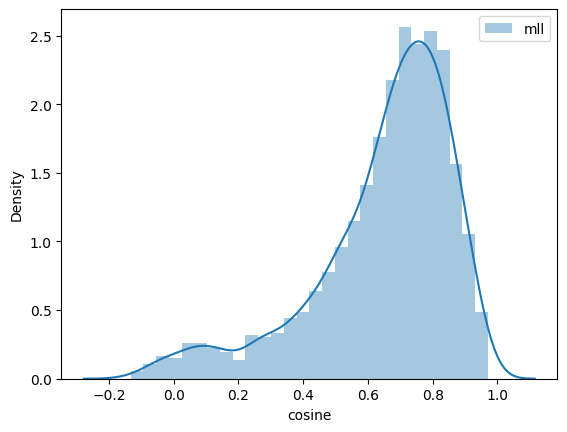

In [70]:
sns.distplot(df_llm['cosine'], label = 'mll')
plt.legend()

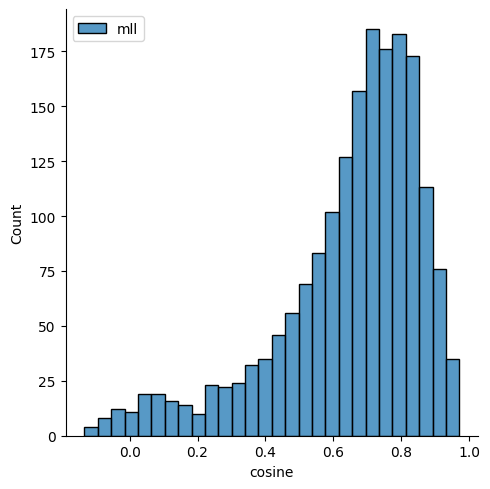

In [71]:
sns.displot(df_llm['cosine'], label = 'mll')
plt.legend()